In [1]:
!pip install sklearn-selector-pipeline

In [3]:
import sklearn_selector_pipeline as sksel

print(sksel.__version__)

0.1.0


=== Regression Feature Selection Example ===
Dataset shape: (500, 20)
Train set: 350 samples
Test set: 150 samples

Fitting FeatureSelectorRegressor...
Selected features: ['feature_03', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_14', 'feature_16', 'feature_17']

=== Regression Metrics ===
Mean Squared Error (MSE): 1641.877
Root Mean Squared Error (RMSE): 40.520
Mean Absolute Error (MAE): 31.043
R² Score: 0.847


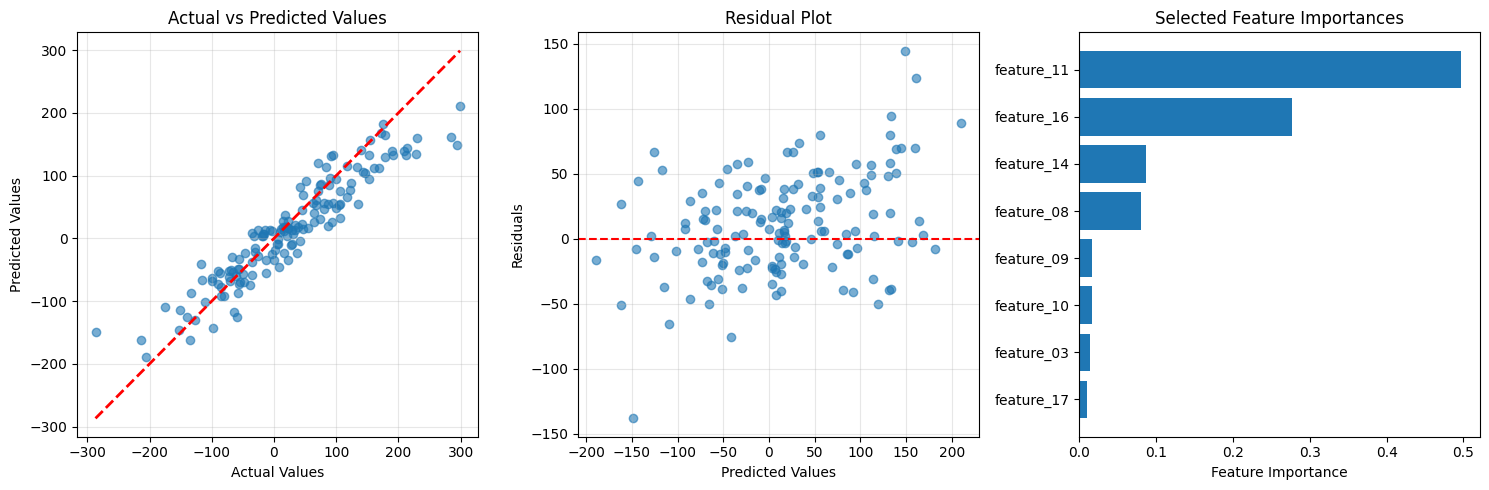


=== Comparison with Baseline (All Features) ===
Selected features R²: 0.847
All features R²: 0.807
Performance difference: 0.040
Feature reduction: 20 → 8 features (60.0% reduction)

=== Incremental Learning Example ===
Batch 2/10: R² = 0.746
Batch 3/10: R² = 0.830
Batch 4/10: R² = 0.887
Batch 5/10: R² = 0.935
Batch 6/10: R² = 0.955
Batch 7/10: R² = 0.963
Batch 8/10: R² = 0.977
Batch 9/10: R² = 0.983
Batch 10/10: R² = 0.987


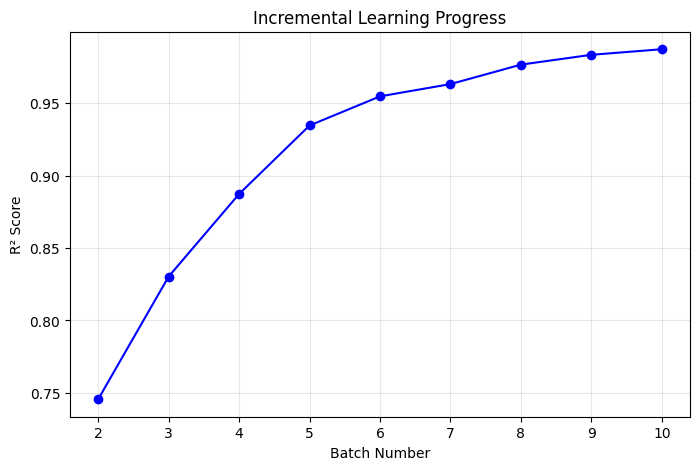

In [5]:
"""
Example: Using FeatureSelectorRegressor with Boston Housing dataset equivalent.

This demonstrates regression feature selection and evaluation.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn_selector_pipeline import FeatureSelectorRegressor


def create_housing_like_dataset(n_samples=500, n_features=20, n_informative=8, noise=10, random_state=42):
    """Create a regression dataset similar to Boston Housing."""
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        random_state=random_state
    )

    # Add some feature names for demonstration
    feature_names = [f"feature_{i:02d}" for i in range(n_features)]

    return X, y, feature_names


def evaluate_regression_pipeline():
    """Demonstrate FeatureSelectorRegressor on a synthetic housing dataset."""

    # Create dataset
    X, y, feature_names = create_housing_like_dataset()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    print("=== Regression Feature Selection Example ===")
    print(f"Dataset shape: {X.shape}")
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Create feature selector and regressor
    selector = SelectKBest(score_func=f_regression, k=8)
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Wrap them together
    wrapped = FeatureSelectorRegressor(feature_selector=selector, regressor=regressor)

    print("\nFitting FeatureSelectorRegressor...")
    wrapped.fit(X_train, y_train)

    # Get selected features
    if hasattr(wrapped.feature_selector_, 'get_support'):
        selected_mask = wrapped.feature_selector_.get_support()
        selected_indices = np.where(selected_mask)[0]
        print(f"Selected features: {[feature_names[i] for i in selected_indices]}")

    # Make predictions
    y_pred = wrapped.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== Regression Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R² Score: {r2:.3f}")

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Plot 1: Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True, alpha=0.3)

    # Plot 2: Residuals
    plt.subplot(1, 3, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    # Plot 3: Feature importance (if available)
    plt.subplot(1, 3, 3)
    if hasattr(wrapped.regressor_, 'feature_importances_'):
        importances = wrapped.regressor_.feature_importances_
        selected_features = [feature_names[i] for i in selected_indices]

        # Sort by importance
        sorted_idx = np.argsort(importances)[::-1]
        sorted_features = [selected_features[i] for i in sorted_idx]
        sorted_importances = importances[sorted_idx]

        plt.barh(range(len(sorted_features)), sorted_importances)
        plt.yticks(range(len(sorted_features)), sorted_features)
        plt.xlabel('Feature Importance')
        plt.title('Selected Feature Importances')
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, 'Feature importances\nnot available',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Importances')

    plt.tight_layout()
    plt.show()

    # Compare with baseline (all features)
    print(f"\n=== Comparison with Baseline (All Features) ===")
    baseline_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    baseline_regressor.fit(X_train, y_train)
    baseline_pred = baseline_regressor.predict(X_test)
    baseline_r2 = r2_score(y_test, baseline_pred)

    print(f"Selected features R²: {r2:.3f}")
    print(f"All features R²: {baseline_r2:.3f}")
    print(f"Performance difference: {r2 - baseline_r2:.3f}")
    print(f"Feature reduction: {X.shape[1]} → {len(selected_indices)} features "
          f"({(1 - len(selected_indices)/X.shape[1])*100:.1f}% reduction)")


def demonstrate_partial_fit():
    """Demonstrate incremental learning with FeatureSelectorRegressor."""

    print(f"\n=== Incremental Learning Example ===")

    # Create larger dataset for incremental learning
    X, y, _ = create_housing_like_dataset(n_samples=1000, random_state=42)

    # Use SGD regressor for incremental learning
    from sklearn.linear_model import SGDRegressor

    selector = SelectKBest(score_func=f_regression, k=10)
    regressor = SGDRegressor(max_iter=1, random_state=42)

    wrapped = FeatureSelectorRegressor(selector, regressor)

    # Simulate streaming data
    batch_size = 100
    n_batches = X.shape[0] // batch_size

    scores = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]

        # Partial fit
        wrapped.partial_fit(X_batch, y_batch)

        # Evaluate on the batch
        if i > 0:  # Skip first batch as it might not be representative
            score = wrapped.score(X_batch, y_batch)
            scores.append(score)
            print(f"Batch {i+1}/{n_batches}: R² = {score:.3f}")

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, len(scores)+2), scores, 'b-', marker='o')
    plt.xlabel('Batch Number')
    plt.ylabel('R² Score')
    plt.title('Incremental Learning Progress')
    plt.grid(True, alpha=0.3)
    plt.show()


if __name__ == "__main__":
    evaluate_regression_pipeline()
    demonstrate_partial_fit()
